# Initialization

In [1]:
# %load init.ipy
%reload_ext autoreload
%autoreload 2

# %load init.ipy
import os, sys, logging, datetime, warnings, shutil
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from nose import tools

import tqdm
import memory_profiler as mpro

import kalepy as kale
import kalepy.utils
import kalepy.plot
# from kalepy.plot import nbshow   # NOTE: this should be upgraded to `plot_control`
# from kalepy.plot import plot_control

def _save_fig(fig, fname, **kwargs):
    kwargs.setdefault('path', kale._PATH_NB_OUT)
    kwargs.setdefault('rename', True)
    return kale.plot._save_fig(fig, fname, **kwargs)
    
save_fig = _save_fig

In [2]:
def save_fig(fig, fname, **kwargs):
    kwargs.setdefault('subdir', 'plotting')
    return _save_fig(fig, fname, **kwargs)

In [3]:
import kalepy as kale

reload(kale.kde)
reload(kale.kernels)
reload(kale.utils)
reload(kale.plot)
reload(kale)

<module 'kalepy' from '/Users/lzkelley/Programs/kalepy/kalepy/__init__.py'>

# 1D Distributions

## 1D - Data Only

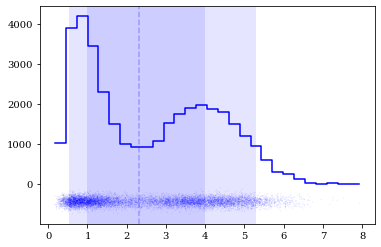

In [4]:
# Generate randomish data
data, _ = kale.utils._random_data_1d_01()
color = 'b'
# Plot 1D Histogram
kale.plot.hist1d(data, color=color, density=True)
# Add "carpet" plot (1D scatter) 
kale.plot.carpet(data, color=color)
# Add median and confidence intervals
kale.plot.confidence(data, quantiles=[0.5, 0.9], color=color)

Overplot two distributions using the same bin-sizes

(<matplotlib.collections.PathCollection at 0x7fe291864eb0>,
 array([-0.03826692, -0.00724528]))

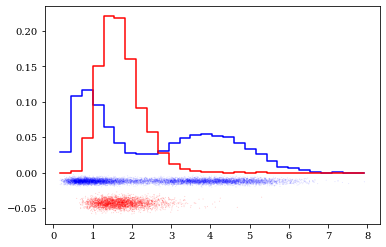

In [5]:
# Generate randomish data
data1, _ = kale.utils._random_data_1d_01()
data2 = np.random.lognormal(0.5, 0.3, size=data1.size//3)

kw = dict(
    probability=True,    # normalize so that the sum of all bins is unity
)

# Plot first dataset in blue and store bin-edges
_, edges, _ = kale.plot.hist1d(data1, color='b', **kw)
# Add carpet plot
kale.plot.carpet(data1, color='b')

# Plot second dataset in red using previous bin-edges
kale.plot.hist1d(data2, edges=edges, color='r', **kw)
# Add carpet plot, and shift it downwards
kale.plot.carpet(data2, color='r', shift=-0.02)


## 1D - KDE 

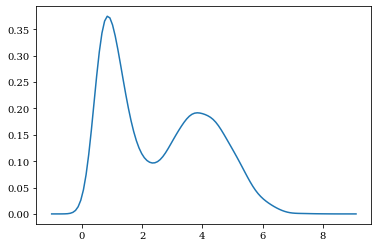

In [6]:
# Generate randomish data
data, _ = kale.utils._random_data_1d_01()
# Calculate the KDE density distribution
edges, pdf = kale.density(data, probability=True)
# Simple line plot
plt.plot(edges, pdf);

Using the kalepy `dist1d` plotting function:

TypeError: dist1d() got an unexpected keyword argument 'contour'

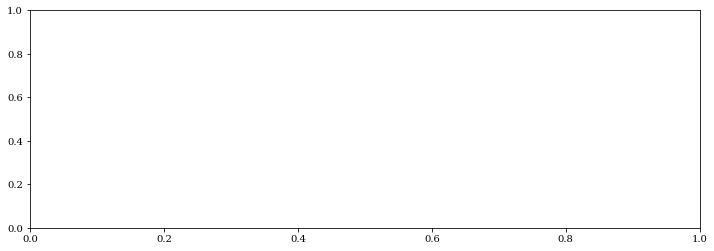

In [7]:
# Generate randomish data
data, _ = kale.utils._random_data_1d_01()
# Plot the KDE and the data (using histogram and carpet plots)
fig, ax = plt.subplots(figsize=[12, 4])
kale.plot.dist1d(data, ax=ax, hist=True, carpet=True, contour=False)

# 2D Distributions

2D - Data Only

In [ ]:
# Generate randomish data
data = kale.utils._random_data_2d_01(num=1e4)

# Standard 2D Histogram, mask empty bins
kale.hist2d(data, cmap='Reds', mask_below=True);
# Contours
kale.contour(data, cmap='Reds_r');

Vary contour smoothing and upsampling

In [ ]:
# Generate randomish data
data = kale.utils._random_data_2d_01(num=1e4)

fig, axes = plt.subplots(figsize=[14, 4], ncols=3)
upsample = [None, 4, None]
smooth = [None, None, 1.0]

for ax, up, sm in zip(axes, upsample, smooth):
    title = f"smooth={sm}, upsample={up}"
    ax.set_title(title)
    # Standard 2D Histogram, mask empty bins
    kale.plot.hist2d(data, ax=ax, cmap='Reds', mask_below=True);
    # Contours
    kale.plot.contour(data, ax=ax, cmap='Reds_r', upsample=up, smooth=sm);
    
plt.show()

## 2D - with KDE

just a KDE using matplotlib contours

In [ ]:
# Generate random-ish data
data = kale.utils._random_data_2d_01(num=1e3)

# Calculate PDF from KDE
points, pdf = kale.density(data)

# Simple contour plot
plt.contour(*points, pdf.T);

Using the kalepy `dist2d` plotting function

In [ ]:
# Generate random-ish data
data = kale.utils._random_data_2d_01(num=1e3)
# Plot data as scatter and histogram, and KDE as contours
kale.plot.dist2d(data);

Compare KDE contours with data contours

In [ ]:
# Generate random-ish data
data = kale.utils._random_data_2d_01(num=1e3)
# Plot data as scatter and histogram, and KDE as contours
kale.plot.dist2d(data, hist=False);
# Compare against contours from data
kale.plot.contour(data, cmap='Reds', ls='--', lw=2.0, alpha=0.5);
# Zoom in a little
plt.gca().set(xlim=[-5, 5], ylim=[-1, 1]);

Compare two different distributions

In [ ]:
# Generate random-ish data
data1 = kale.utils._random_data_2d_02(num=2e3)
data2 = kale.utils._random_data_2d_03(num=2e3)

# Plot data as scatter and KDE as contours
# Data 1
kale.plot.dist2d(data1, hist=False, cmap='Reds');
# Data 2
kale.plot.dist2d(data2, hist=False, cmap='Blues');

# Multidimensional Corner / Pair Plots

## Corner - Data Only

In [ ]:
reload(kale.plot)

In [ ]:
# Generate randomish data
data = kale.utils._random_data_3d_01()
# Initialize a corner plot with the given data, set axes labels
corner = kale.plot.Corner(data, labels=['a', 'b', 'c'], figsize=8)
# Plot with default settings
corner.plot_data()

In [ ]:
# Generate randomish data
data = kale.utils._random_data_3d_01()
# Initialize a corner plot with the given data, set axes labels
corner = kale.plot.Corner(data, labels=['a', 'b', 'c'], figsize=8)
# Plot and add 2D contours, and change color
corner.plot_data(dist2d=dict(contour=True), color='purple')

In [ ]:
# Generate randomish data
data = kale.utils._random_data_3d_01()
# Initialize a corner plot with the given data, set axes labels
corner = kale.plot.Corner(data, labels=['a', 'b', 'c'], figsize=8)
# Plot with only histograms
corner.hist(color='firebrick')

# Corner - with KDE

In [ ]:
data = kale.utils._random_data_3d_03()

# Plot with default settings
kale.corner(data);

In [ ]:
data = kale.utils._random_data_3d_03()

# Plot with default settings
kale.plot_kde(data);

Overplot two distributions: compare with and without reflection

In [ ]:
data = kale.utils._random_data_3d_03()

# construct a `Corner` instance
corner = kale.Corner(
    3,                                         # set the number of dimensions/parameters
    figsize=[11, 9],                           # manually set the figure size
    limits=[[-0.5, 2], [-3, 3], [-0.1, 1.1]],  # manually set the axes limits for each parameter
)

# Construct a KDE with*out* reflection
clear = kale.KDE(data)

# Construct a KDE *with* reflection (one sides on the 0th and 2nd dimensions)
reflect = kale.KDE(data, reflect=[[0, None], None, [None, 1]])
quants = [0.1, 0.5, 0.9]
# Use the `kalepy.plot.Corner.clean()` function for only PDF and contours
corner.clean(clear, cmap='Reds', quantiles=quants);
corner.clean(reflect, cmap='Blues', quantiles=quants);

# Other

## Weighted Data

In [ ]:
xx = np.random.normal(size=1000)
yy = 100*np.fabs(xx)

plt.figure(figsize=[10, 4])
kde = kale.KDE(xx, weights=yy)
edges, pdf = kde.pdf()
_, ee, h1 = kale.hist1d(xx, ls='--', color='k', probability=True, density=True, lw=2.0)

h2 = kale.plot.dist1d(kde, edges=edges, carpet=False)
h3 = kale.plot.dist1d(xx, edges=ee, hist=True, weights=yy, color='r')

plt.legend([h1, h2, h3], ['unweighted', 'KDE', 'weighted']);